# 1. Preprocessing

## 1.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')

## 1.2 Check images size

In [2]:
from PIL import Image
import os

img_shapes = []
root_dir = "G:\Projects\Cellula_Internship\Teeth_Classification_Project\Teeth_Dataset\Training"

for class_dir in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_dir)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            img_shapes.append(img.size)

# See unique image sizes
unique_sizes = set(img_shapes)
print(unique_sizes)

img_shapes = []
root_dir = "G:\Projects\Cellula_Internship\Teeth_Classification_Project\Teeth_Dataset\Validation"

for class_dir in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_dir)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            img_shapes.append(img.size)

# See unique image sizes
unique_sizes = set(img_shapes)
print(unique_sizes)

img_shapes = []
root_dir = "G:\Projects\Cellula_Internship\Teeth_Classification_Project\Teeth_Dataset\Testing"

for class_dir in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_dir)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            img_shapes.append(img.size)

# See unique image sizes
unique_sizes = set(img_shapes)
print(unique_sizes)


{(256, 256)}
{(256, 256)}
{(32, 32), (256, 256), (64, 64)}


### We now understand that Training and Validation images all are of same size but, there are some images in the test set which are of different size. We should take only the images of the 7 classes and neglect the "Output" folders (may be it represents the result of a previous model).

## 1.3 Import Dataset

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the path to your dataset folders
data_dir = "G:\Projects\Cellula_Internship\Teeth_Classification_Project\Teeth_Dataset"  # Replace this with the actual root folder path

# Image and batch settings
img_height = 256
img_width = 256
batch_size = 32

# Load training, validation, and test sets from directories
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{data_dir}/training",
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{data_dir}/validation",
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{data_dir}/Testing",
    labels='inferred',
    label_mode='int',
    class_names=['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT'],  # importing the 7 classes only neglecting the output folders
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

class_names = train_ds.class_names


Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


## 1.4 Display Sample of Raw Images

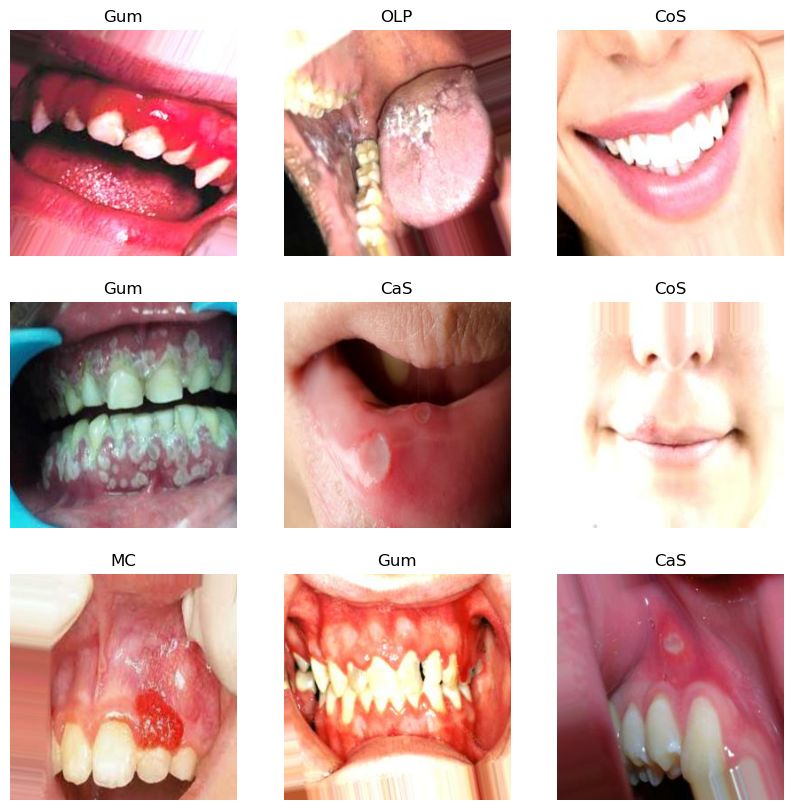

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 1.5 Augment Data

In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),         # Flip horizontally
    tf.keras.layers.RandomRotation(0.1),              # Rotate ±25%
    tf.keras.layers.RandomZoom(0.1),                  # Slight zoom
    tf.keras.layers.RandomBrightness(factor=0.1),     # Slight brightness change
])

train_ds_aug = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

## 1.6 Display Sample of Augmented Images

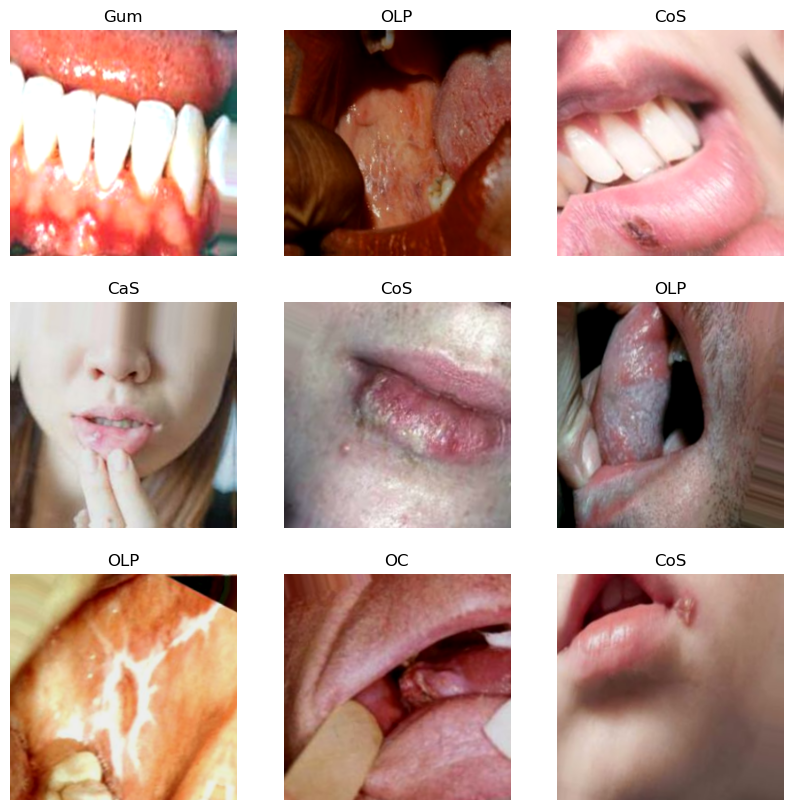

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_aug.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 1.7 Combine Raw and Augmented Training Data

In [7]:
combined_train_ds = train_ds.concatenate(train_ds_aug)

In [8]:
total_images = 0
for images, labels in combined_train_ds:
    total_images += images.shape[0]  # number of images in the batch

print("✅ Total images in combined_train_ds:", total_images)

✅ Total images in combined_train_ds: 6174


## 1.8 Normalize Data

In [9]:
# Normalize the pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds_norm = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds_norm = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds_norm = test_ds.map(lambda x, y: (normalization_layer(x), y))

print("✅ Data loaded and normalized successfully.")

✅ Data loaded and normalized successfully.


### We normalized the original training data NOT the augmented training data as after various experiments we observed that data augmentation led to very bad model performance.

## 1.9 Display Sample of Normalized Images

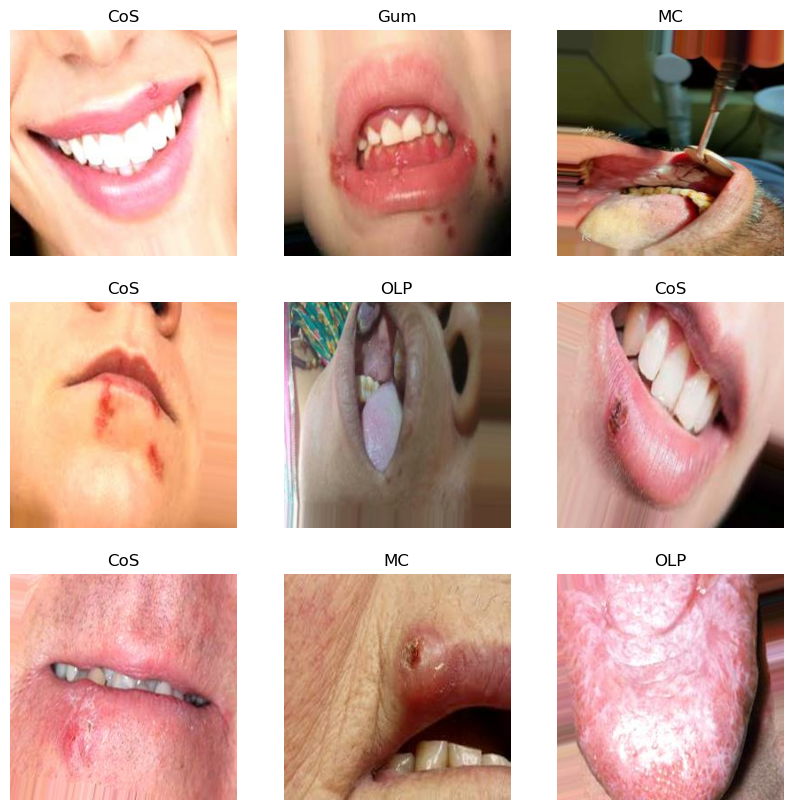

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_norm.take(1):  # train_ds is normalized
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())  # no need to cast or rescale
        plt.title(class_names[labels[i]])
        plt.axis("off")

# 2. Visualization

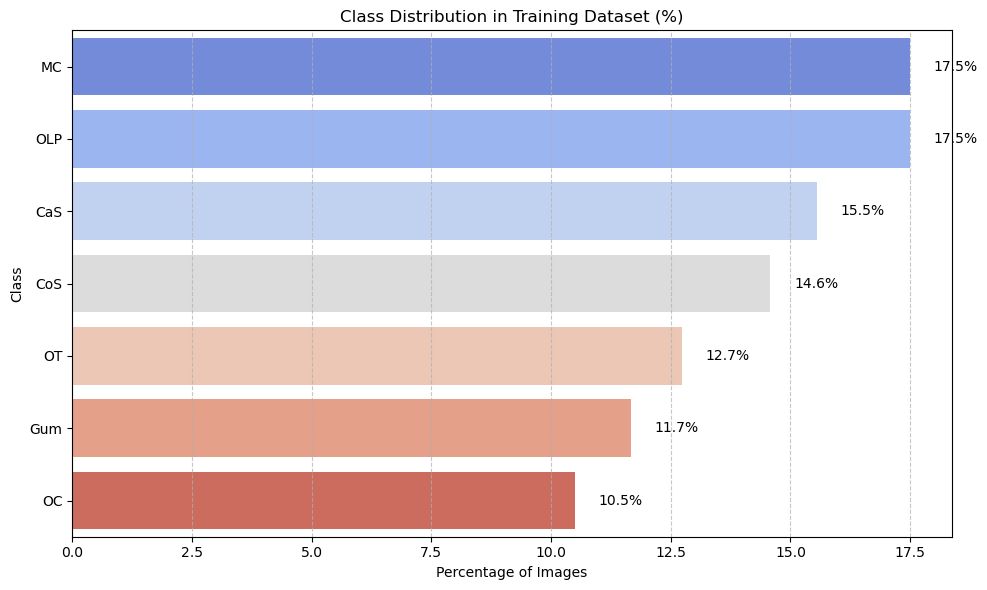

In [11]:
# Path to your training dataset
train_dir = "G:/Projects/Cellula_Internship/Teeth_Classification_Project/Teeth_Dataset/Training"  # update if needed

# Count images per class
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([
            file for file in os.listdir(class_path)
            if file.lower().endswith((".jpg", ".jpeg", ".png"))
        ])
        class_counts[class_name] = num_images

# Convert to DataFrame
df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])
total_images = df["Image Count"].sum()
df["Percentage"] = (df["Image Count"] / total_images) * 100
df = df.sort_values("Percentage", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="Percentage", y="Class", data=df, palette="coolwarm")

# Add percentage labels on bars
for i, p in enumerate(barplot.patches):
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    barplot.text(width + 0.5, y, f'{df["Percentage"].iloc[i]:.1f}%', va='center')

# Styling
plt.title("Class Distribution in Training Dataset (%)")
plt.xlabel("Percentage of Images")
plt.ylabel("Class")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### This level of imbalance does NOT require urgent action may be class weights can be used later in model training.

# 3. Model Building

## 3.1 Define Model Architecture

In [12]:
from tensorflow.keras import layers, models

model = tf.keras.Sequential([
    layers.Input(shape=(256, 256, 3)),

    # Block 1
    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),

    # Block 4 (new)
    layers.Conv2D(256, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),

    # Block 5 (new)
    layers.Conv2D(256, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),

    # Head
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(7, activation='softmax')
])

### Used GAP instead of Flatten to reduce the number of parameters and improve model performance.

In [13]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,                 # Wait 3 epochs with no improvement
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',   
    save_best_only=True,
    verbose=1
)

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,89

 Total params: 1,015,239 (3.87 MB)

 Trainable params: 1,013,767 (3.87 MB)

 Non-trainable params: 1,472 (5.75 KB)

## 3.2 Define Class Weights

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

# Assume your training directory structure is already sorted
train_dir = "G:\Projects\Cellula_Internship\Teeth_Classification_Project\Teeth_Dataset\Training"
class_names = sorted(os.listdir(train_dir))  # should match model class order

# Build full label list
y_labels = []
for idx, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    num_images = len([
        file for file in os.listdir(class_path)
        if file.lower().endswith((".jpg", ".jpeg", ".png"))
    ])
    y_labels.extend([idx] * num_images)

# Compute weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_labels),
    y=y_labels
)

# Convert to dict
class_weights = dict(enumerate(class_weights_array))
print("✅ Class weights:", class_weights)

✅ Class weights: {0: np.float64(0.91875), 1: np.float64(0.98), 2: np.float64(1.225), 3: np.float64(0.8166666666666667), 4: np.float64(1.3611111111111112), 5: np.float64(0.8166666666666667), 6: np.float64(1.1221374045801527)}


## 3.3 Model Training

```python

### After various experiments data augmentation is NOT used in training as it was not improving the model performance. so, we will use the original training data.
```

In [17]:
history = model.fit(
    train_ds_norm,
    validation_data=val_ds_norm,
    epochs=40,
    callbacks=[checkpoint],
    class_weight=class_weights 
)

Epoch 1/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2698 - loss: 1.9581
Epoch 1: val_accuracy improved from -inf to 0.17218, saving model to best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 548s 6s/step - accuracy: 0.2702 - loss: 1.9563 - val_accuracy: 0.1722 - val_loss: 2.6946
Epoch 2/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3751 - loss: 1.5967
Epoch 2: val_accuracy did not improve from 0.17218
97/97 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - accuracy: 0.3753 - loss: 1.5964 - val_accuracy: 0.1498 - val_loss: 3.5980
Epoch 3/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4100 - loss: 1.4957
Epoch 3: val_accuracy improved from 0.17218 to 0.22179, saving model to best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 485s 5s/step - accuracy: 0.4102 - loss: 1.4955 - val_accuracy: 0.2218 - val_loss: 3.4672
Epoch 4/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4415 - loss: 1.4128
Epoch 4: val_accuracy improved from 0.22179 to 0.29864, saving model to best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 487s 5s/step - accuracy: 0.4416 - loss: 1.4126 - val_accuracy: 0.2986 - val_loss: 2.4309
Epoch 5/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4952 - loss: 1.3219
Epoch 5: val_accuracy improved from 0.29864 to 0.33171, saving model to best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 771s 8s/step - accuracy: 0.4952 - loss: 1.3218 - val_accuracy: 0.3317 - val_loss: 2.1730
Epoch 6/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5232 - loss: 1.2375
Epoch 6: val_accuracy improved from 0.33171 to 0.34339, saving model to best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 763s 8s/step - accuracy: 0.5233 - loss: 1.2375 - val_accuracy: 0.3434 - val_loss: 2.2612
Epoch 7/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5438 - loss: 1.2124
Epoch 7: val_accuracy improved from 0.34339 to 0.42412, saving model to best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 744s 8s/step - accuracy: 0.5440 - loss: 1.2120 - val_accuracy: 0.4241 - val_loss: 1.5796
Epoch 8/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5761 - loss: 1.1065
Epoch 8: val_accuracy did not improve from 0.42412
97/97 ━━━━━━━━━━━━━━━━━━━━ 492s 5s/step - accuracy: 0.5762 - loss: 1.1064 - val_accuracy: 0.4115 - val_loss: 1.5731
Epoch 9/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5933 - loss: 1.0413
Epoch 9: val_accuracy did not improve from 0.42412
97/97 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - accuracy: 0.5935 - loss: 1.0412 - val_accuracy: 0.4047 - val_loss: 1.6005
Epoch 10/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6146 - loss: 1.0207
Epoch 10: val_accuracy improved from 0.42412 to 0.51654, saving model to best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 487s 5s/step - accuracy: 0.6148 - loss: 1.0204 - val_accuracy: 0.5165 - val_loss: 1.3616
Epoch 11/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6629 - loss: 0.9027
Epoch 11: val_accuracy improved from 0.51654 to 0.58755, saving model to best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - accuracy: 0.6630 - loss: 0.9027 - val_accuracy: 0.5875 - val_loss: 1.1106
Epoch 12/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6755 - loss: 0.8521
Epoch 12: val_accuracy improved from 0.58755 to 0.63230, saving model to best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 490s 5s/step - accuracy: 0.6756 - loss: 0.8519 - val_accuracy: 0.6323 - val_loss: 0.9963
Epoch 13/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7000 - loss: 0.7923
Epoch 13: val_accuracy did not improve from 0.63230
97/97 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - accuracy: 0.6999 - loss: 0.7925 - val_accuracy: 0.5661 - val_loss: 1.1828
Epoch 14/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7119 - loss: 0.7965
Epoch 14: val_accuracy did not improve from 0.63230
97/97 ━━━━━━━━━━━━━━━━━━━━ 481s 5s/step - accuracy: 0.7119 - loss: 0.7964 - val_accuracy: 0.4056 - val_loss: 2.0154
Epoch 15/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7173 - loss: 0.7538
Epoch 15: val_accuracy did not improve from 0.63230
97/97 ━━━━━━━━━━━━━━━━━━━━ 480s 5s/step - accuracy: 0.7174 - loss: 0.7537 - val_accuracy: 0.6167 - val_loss: 1.0754
Epoch 16/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7403 - loss: 0.6954
Epoch 16: val_accuracy did not improve from 

97/97 ━━━━━━━━━━━━━━━━━━━━ 482s 5s/step - accuracy: 0.8411 - loss: 0.4592 - val_accuracy: 0.6770 - val_loss: 0.9114
Epoch 24/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8423 - loss: 0.4301
Epoch 24: val_accuracy improved from 0.67704 to 0.75389, saving model to best_model.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 480s 5s/step - accuracy: 0.8424 - loss: 0.4298 - val_accuracy: 0.7539 - val_loss: 0.6923
Epoch 25/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8473 - loss: 0.4111
Epoch 25: val_accuracy did not improve from 0.75389
97/97 ━━━━━━━━━━━━━━━━━━━━ 479s 5s/step - accuracy: 0.8473 - loss: 0.4112 - val_accuracy: 0.6858 - val_loss: 1.0239
Epoch 26/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8544 - loss: 0.4139
Epoch 26: val_accuracy did not improve from 0.75389
97/97 ━━━━━━━━━━━━━━━━━━━━ 479s 5s/step - accuracy: 0.8545 - loss: 0.4137 - val_accuracy: 0.7082 - val_loss: 1.0799
Epoch 27/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8634 - loss: 0.3820
Epoch 27: val_accuracy did not improve from 0.75389
97/97 ━━━━━━━━━━━━━━━━━━━━ 484s 5s/step - accuracy: 0.8634 - loss: 0.3819 - val_accuracy: 0.6722 - val_loss: 1.1258
Epoch 28/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8738 - loss: 0.3326
Epoch 28: val_accuracy did not improve from 

97/97 ━━━━━━━━━━━━━━━━━━━━ 481s 5s/step - accuracy: 0.8954 - loss: 0.3009 - val_accuracy: 0.7840 - val_loss: 0.6373
Epoch 34/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9218 - loss: 0.2239
Epoch 34: val_accuracy did not improve from 0.78405
97/97 ━━━━━━━━━━━━━━━━━━━━ 502s 5s/step - accuracy: 0.9218 - loss: 0.2239 - val_accuracy: 0.5798 - val_loss: 1.7184
Epoch 35/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9036 - loss: 0.2733
Epoch 35: val_accuracy did not improve from 0.78405
97/97 ━━━━━━━━━━━━━━━━━━━━ 491s 5s/step - accuracy: 0.9037 - loss: 0.2730 - val_accuracy: 0.7422 - val_loss: 0.8402
Epoch 36/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9099 - loss: 0.2620
Epoch 36: val_accuracy did not improve from 0.78405
97/97 ━━━━━━━━━━━━━━━━━━━━ 490s 5s/step - accuracy: 0.9099 - loss: 0.2620 - val_accuracy: 0.5185 - val_loss: 2.1322
Epoch 37/40
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9086 - loss: 0.2663
Epoch 37: val_accuracy did not improve from 

97/97 ━━━━━━━━━━━━━━━━━━━━ 482s 5s/step - accuracy: 0.9388 - loss: 0.1851 - val_accuracy: 0.7967 - val_loss: 0.6617


## 3.4 Model Evaluation

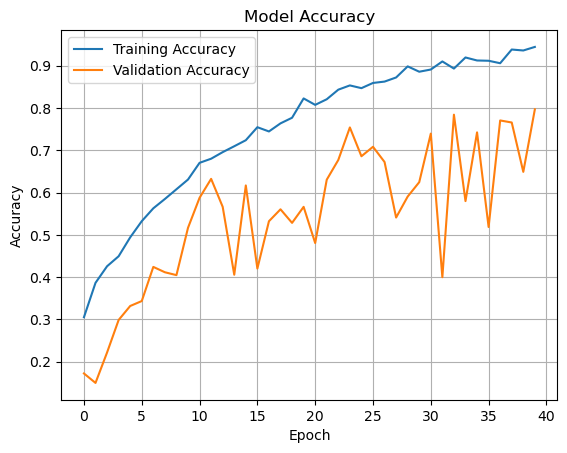

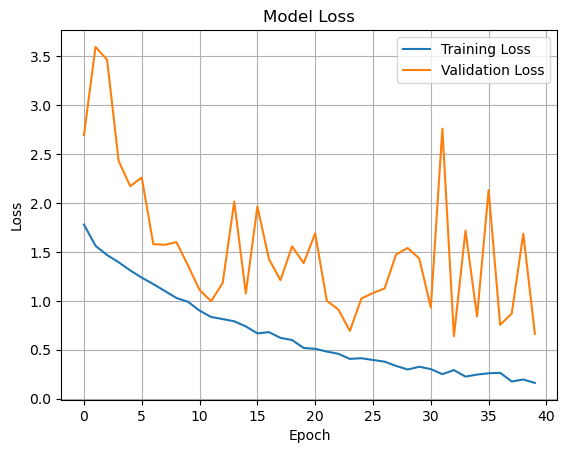

In [18]:
# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
test_loss, test_accuracy = model.evaluate(test_ds_norm)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 902ms/step - accuracy: 0.8333 - loss: 0.5819
✅ Test Accuracy: 0.8142
📉 Test Loss: 0.6426


In [20]:
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds_norm:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━

<Figure size 800x600 with 0 Axes>

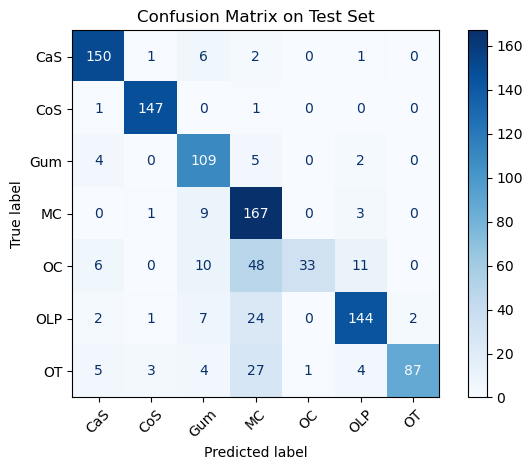

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate matrix
cm = confusion_matrix(y_true, y_pred)
class_names = test_ds.class_names  # assumes same order

# Plot
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

In [22]:
model.save("Oral_Disease_Classifier.h5")